# Линейная регрессия: аналитическое решение

### АНАЛИТИЧЕСКОЕ РЕШЕНИЕ С ПОМОЩЬЮ NUMPY

Вот какие этапы нам предстоит пройти, чтобы построить свою модель:

* Загрузить данные и проанализировать датасет на предмет пропусков.
* Подготовить данные для подачи в модель: избавиться от пропусков, если они есть, и перекодировать категориальные признаки, если они представлены текстом.
* Построить модель. Будем строить несколько моделей линейной регрессии: первую — на одном признаке, вторую — на всех доступные признаках.
* Оценить качество модели.

Для начала импортируем необходимые вспомогательные библиотеки:

In [4]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
%matplotlib inline
plt.style.use('seaborn') #установка стиля matplotlib

C:\Users\jkons\AppData\Local\Temp\ipykernel_15340\546158159.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #установка стиля matplotlib


Будем работать с датасетом из библиотеки sklearn о домах в Бостоне. Этот набор данных содержит информацию, собранную службой переписи населения США и касающуюся жилья в районе Бостона, штат Массачусетс.

Данный датасет содержится в модуле datasets библиотеки sklearn. Давайте загрузим датасет с помощью функции load_boston() и выведем его описание, обратившись по ключу 'DESCR':

In [6]:
column_names = [
    'CRIM',    # уровень преступности на душу населения по городам
    'ZN',      # доля земли под жилую застройку, разделённая на участки площадью более 25 000 кв. футов
    'INDUS',   # доля акров, которые принадлежат предприятиям, не связанным с розничной торговлей, на город
    'CHAS',    # фиктивная переменная реки Чарльз (1 — если участок прилегает к реке; 0 — в противном случае)
    'NOX',     # концентрация оксидов азота (в десятимиллионных долях)
    'RM',      # среднее количество комнат в доме
    'AGE',     # доля зданий, построенных до 1940 г. и занимаемых владельцами
    'DIS',     # взвешенные расстояния до пяти бостонских центров занятости
    'RAD',     # индекс доступности радиальных автомобильных дорог
    'TAX',     # полная ставка налога на имущество за каждые 10 000 долларов стоимости
    'PTRATIO', # соотношение учеников и учителей по городам
    'B',       # 1000 * (Bk — 0.63), где Bk — доля граждан афроамериканского происхождения по городам
    'LSTAT',   # процент населения с низким статусом
    'MEDV'     # медианное значение стоимости домов, занимаемых владельцами, в тысячах долларов США (целевой признак)
]
boston_data = pd.read_csv('data/housing.csv', header=None, delimiter=r"\s+", names=column_names)
boston_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


Выведем информацию о таблице boston_data с помощью метода info():

In [7]:
boston_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


*Примечание. Модель линейной регрессии требует, чтобы в подаваемых ей на вход данных не было пропущенных значений. Поэтому если в ваших данных окажутся пропуски, обязательно заранее позаботьтесь о них.*

Итак, в наших данных нет пропусков, а значит их можно подавать в модель, чтобы обучить её предсказывать целевой признак (признак MEDV).

*Также модель не умеет работать с категориальными признаками, представленными в виде типа object. Прежде чем подавать в модель линейной регрессии категориальные признаки, необходимо произвести кодировку категорий с помощью уже знакомых вам методов кодирования.*

→ Давайте начнём с простого. Построим линейную регрессию на одном признаке. Выберем признак, который имеет наиболее высокую линейную взаимосвязь. Для этого рассчитаем корреляцию признаков с целевой переменной и выберем наиболее влиятельный.

Для лучшего восприятия давайте построим столбчатую диаграмму для модульного значения корреляций:

*Примечание. Мы могли визуализировать матрицу корреляций, однако сейчас нас интересует только связь факторов с целевым признаком, поэтому нагляднее будет воспользоваться столбчатой диаграммой.*

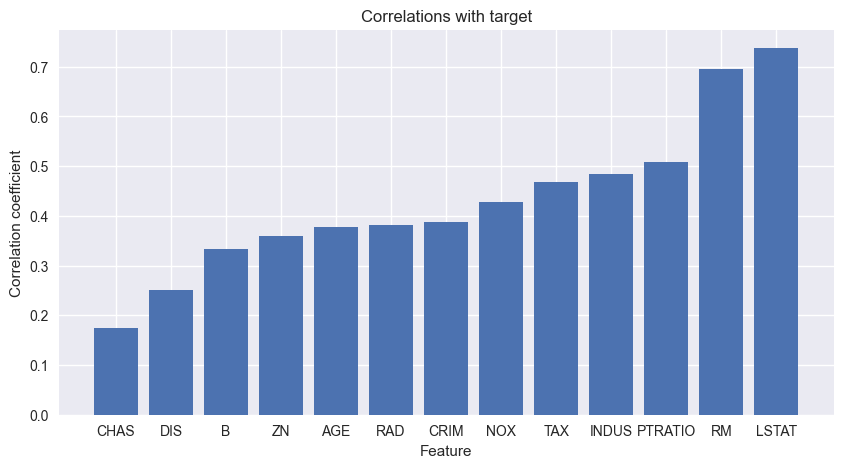

In [8]:
#Вычисляем модуль корреляции
corr_with_target = boston_data.corr()['MEDV'].abs().sort_values()
#Удаляем корреляцию целевой переменной с самой собой
corr_with_target = corr_with_target.drop('MEDV')
#Строим столбчатую диаграмму корреляций
fig, ax = plt.subplots(figsize=(10, 5)) #фигура+координатная плоскость
ax.bar(corr_with_target.index, corr_with_target.values) #столбчатая диаграмма
ax.set_title('Correlations with target') #название графика
ax.set_xlabel('Feature') #название оси x
ax.set_ylabel('Сorrelation coefficient'); #название оси y

Итак, самый коррелированный по модулю с медианной ценой (MEDV) признак — процент населения с низким статусом (LSTAT). Давайте построим линейную регрессию, используя этот признак.

*Примечание. Построить линейную регрессию = обучить линейную регрессию = найти её параметры.*

Вспоминаем нашу формулу аналитического решения по методу наименьших квадратов:

![метод наименьших квадратов](img/form_met_naim_kv.png)

Что есть X и y? Это матрица из примеров (матрица наблюдений) и вектор правильных ответов к ним соответственно. У нас матрица X — это таблица, состоящая из одного столбца (LSTAT), а y — столбец с медианными ценами (MEDV):

In [9]:
X = boston_data[['LSTAT']] #матрица наблюдений
y = boston_data['MEDV'] #вектор правильных ответов
X.head()
#y.head()

,LSTAT
0,4.98
1,9.14
2,4.03
3,2.94
4,5.33


*Примечание. Двойные квадратные скобки **boston_data[['LSTAT']]** позволяют выбрать признак из DataFrame, сохранив его в виде таблицы. Это важно, так как в формуле МНК X — это матрица.*

У нас есть все компоненты формулы, чтобы найти параметры модели. Давайте напишем функцию *linear_regression()*, в которой реализуем вычисления коэффициентов. Аргументами функции будут матрица наблюдений X и вектор ответов y, а возвращать она будет вектор параметров w.

Матричные вычисления легче всего реализовать через библиотеку numpy.

Для начала вспомним, что для вычисления свободного члена W0 необходимо добавить в таблицу столбец, полностью состоящий из единиц. Такой столбец можно создать с помощью знакомой нам функции ones() из библиотеки numpy, а присоединить его к таблице X поможет функция column_stack().

Матричное умножение в numpy реализуется с помощью оператора @. Транспонирование осуществляется через .T, а обратная матрица вычисляется с помощью функции *inv()* из модуля *linalg* (модуля для линейной алгебры).

In [10]:
def linear_regression(X, y):
    #Создаём вектор из единиц
    ones = np.ones(X.shape[0])
    #Добавляем вектор к таблице первым столбцом
    X = np.column_stack([ones, X])
    #Вычисляем обратную матрицу Q
    Q = np.linalg.inv(X.T @ X)
    #Вычисляем вектор коэффициентов
    w = Q @ X.T @ y
    return w

Осталось только вызвать нашу функцию и передать в неё нашу таблицу примеров X и столбец правильных ответов y. Вычислим вектор параметров и выведем его на экран:

In [11]:
#Вычисляем параметры линейной регрессии
w = linear_regression(X, y)
#Выводим вычисленные значения параметров в виде вектора
print('Vector w: {}'.format(w))
#Выводим параметры с точностью до двух знаков после запятой
print('w0: {:.2f}'.format(w[0]))
print('w1: {:.2f}'.format(w[1]))
# Vector w: [34.55384088 -0.95004935]
# w0: 34.55
# w1: -0.95

Vector w: [34.55384088 -0.95004935]
w0: 34.55
w1: -0.95


Итак, мы получили значения коэффициентов уравнения прямой. С точностью до сотых они равны:

![form_lin_regr](img/form_lin_regr.png)

Самое приятное в модели линейной регрессии — то, что её коэффициенты можно проинтерпретировать. 

Коэффициент  W0=34.55 имитирует влияние сторонних факторов, которые не учтены в модели. Это значение медианной цены домов на участке, если бы значение процента населения с низким статусом было равно 0. 

Коэффициент  W1=-0.95 означает, на сколько в среднем изменится медианная цена (в тысячах долларов) при увеличении низкостатусного населения на 1 единицу. То есть если количество низкостатусного населения увеличится на 1 %, то медианная цена зданий на участке упадёт на 0.95 тысяч долларов. Можно сказать, что каждый новый процент низкостатусного населения уменьшает медианную цену на 0.95 тысяч долларов.

Теперь, если в данных появится новый участок Бостона с известной долей низкостатусного населения, мы сможем предсказать значение медианной стоимости домов простой подстановкой значений в модель:

In [13]:
#Задаём процент низкостатусного населения
x_example = 5.18 
#Делаем предсказание
y_predict = w[0] + w[1] * x_example
print('Predicted value: {:.2f}'.format(float(y_predict)))
#Predicted value: 29.63

Predicted value: 29.63


Так как мы работаем с одним фактором, то можем построить визуализацию нашей модели.

Давайте напишем функцию plot_regression_2d(), у которой будет три обязательных аргумента (матрица наблюдений X, столбец правильных ответов y и столбец с предсказаниями модели y_pred) и два аргумента по умолчанию (xlabel — подпись оси абсцисс и ylabel — подпись оси ординат).

In [14]:
def plot_regression_2d(X, y_true, y_predict, xlabel='LSTAT', ylabel='MEDV'):
    fig, ax = plt.subplots(figsize=(8, 4)) #фигура + координатная плоскость
    ax.scatter(X, y_true, alpha=0.7, label='Sample data') #диаграмма рассеяния
    ax.plot(X, y_predict, color='black', label='Regression model') #линейный график
    ax.set_xlabel(xlabel) #название оси абсцисс
    ax.set_ylabel(ylabel) #название оси ординат
    ax.legend(facecolor='white', fontsize=11) #легенда

Сделаем предсказание для всех объектов из таблицы X, подставив её в модель линейной регрессии с найденными параметрами, и построим график:

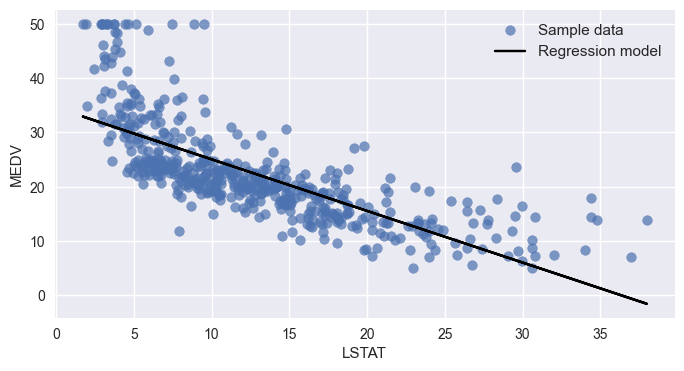

In [15]:
#Делаем предсказание для всех объектов из таблицы
y_predict = w[0] + w[1] * X
#Строим визуализацию
plot_regression_2d(X, y, y_predict)

Как и ожидалось, прямая является убывающей (коэффициент  W1<0), и, если её продолжить влево, она пересечётся с осью ординат в точке W0=34.55. 

*Итак, мы воспользовались формулой для МНК алгоритма и нашли параметры модели линейной регрессии «вручную», реализовав формулу в виде функции. Отметим, что наша функция универсальна: в неё можно подавать не только матрицу X с одним признаком (LSTAT), но и таблицу, содержащую все признаки, описывающие участки.*

*Конечно же, никто не строит линейную регрессию «руками», используя формулу МНК. Все дата-сайентисты пользуются библиотеками, такими как sklearn. Давайте посмотрим на реализацию ↓*

### АНАЛИТИЧЕСКОЕ РЕШЕНИЕ С ПОМОЩЬЮ SKLEARN

Алгоритм построения модели реализован в библиотеке машинного обучения sklearn и находится в модуле linear_model. Давайте импортируем этот модуль:

In [16]:
from sklearn import linear_model

В модуле находится класс LinearRegression, который реализует аналитическое решение линейной регрессии. Для обучения модели необходимо просто вызвать метод fit(), передав в него матрицу наблюдений X и вектор правильных ответов y.

Данный метод реализует формулу метода наименьших квадратов и рассчитает параметры модели самостоятельно. Чтобы получить свободный член W0 нужно обратиться по атрибуту intercept_, а вектор параметров  W1,W2,W3,...,Wm будет храниться в атрибуте coef_ (так как у нас один фактор в матрице X, то и коэффициент будет только один):

In [17]:
#Создаём объект класса LinearRegression
lr_lstat = linear_model.LinearRegression()
#Обучаем модель — ищем параметры по МНК
lr_lstat.fit(X, y)
 
print('w0: {}'.format(lr_lstat.intercept_)) #свободный член w0
print('w1: {}'.format(lr_lstat.coef_)) #остальные параметры модели w1, w2, ..., wm
 
# w0: 34.55384087938311
# w1: [-0.95004935]

w0: 34.5538408793831
w1: [-0.95004935]


*Примечание. Обратите внимание, что мы получили ровно те же самые значения для параметров модели, что является вполне ожидаемым, ведь метод fit() у объекта LinearRegression реализует ту же самую формулу МНК, которую мы прописали в функции linear_regression(). Интерпретация коэффициентов остаётся той же.*

Модель обучена. А как сделать предсказание? Вручную записывать выражение для модели и подставлять коэффициенты? Конечно же, нет. Для этого есть метод predict(). В него необходимо передать матрицу наблюдений, для которых нужно сделать предсказание.

Давайте сделаем предсказание для всех наших наблюдений из таблицы X и визуализируем результат с помощью нашей функции plot_regression_2d():

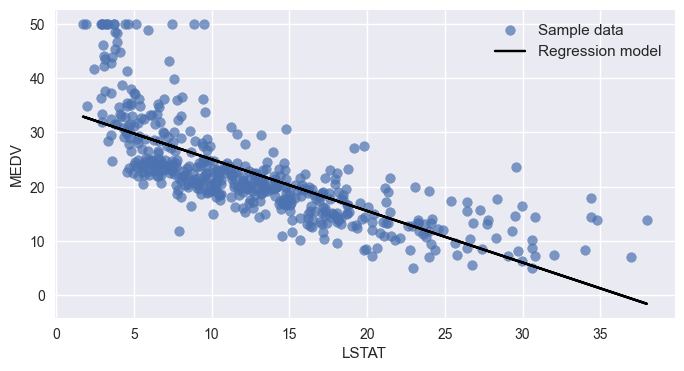

In [18]:
#Предсказываем медианную цену для всех участков из набора данных
y_predict = lr_lstat.predict(X)
#Строим визуализацию
plot_regression_2d(X, y, y_predict)

Получаем тот же самый график, что мы видели ранее, когда реализовывали линейную регрессию вручную.

А что, если мы хотим построить линейную регрессию, используя всю предоставленную информацию, то есть все 13 признаков? Не проблема! Нужно только расширить матрицу наблюдений X, добавив в неё остальные признаки и снова обучить модель LinearRegression.

Давайте выберем из таблицы boston все столбцы, исключая столбец с целевой переменной (MEDV). Полученную матрицу X и вектор правильных ответов y отправляем в метод fit(), чтобы произвести подгонку и найти параметры модели.

In [19]:
#Составляем список факторов (исключили целевой столбец)
features = boston_data.drop('MEDV', axis=1).columns
#Составляем матрицу наблюдений X и вектор ответов y
X = boston_data[features]
y = boston_data['MEDV']
#Создаём объект класса LinearRegression
lr_full = linear_model.LinearRegression()
#Обучаем модель — ищем параметры по МНК
lr_full.fit(X, y)

LinearRegression()

Для удобства составим DataFrame из коэффициентов W1,W2,...,W13  обученной модели, не забыв добавить к нему строку со свободным членом W0:

In [20]:
#Составляем таблицу из признаков и их коэффициентов
w_df = pd.DataFrame({'Features': features, 'Coefficients': lr_full .coef_})
#Составляем строку таблицы со свободным членом
intercept_df =pd.DataFrame({'Features': ['INTERCEPT'], 'Coefficients': lr_full .intercept_})
coef_df = pd.concat([w_df, intercept_df], ignore_index=True)
display(coef_df)

,Features,Coefficients
0,CRIM,-0.108011
1,ZN,0.046420
2,INDUS,0.020559
3,CHAS,2.686734
4,NOX,-17.766611
5,RM,3.809865
6,AGE,0.000692
7,DIS,-1.475567
8,RAD,0.306049
9,TAX,-0.012335


Итак, мы получили таблицу с признаками из нашего набора данных и коэффициентами, которые им соответствуют.

Каждый из коэффициентов в модели показывает, на сколько в среднем (согласно модели) изменится медианная цена (в тысячах долларов) при увеличении параметра на единицу. Например, если уровень преступности увеличится на один пункт, то медианная цена зданий на участке упадёт на 0.1 тыс. долларов. А вот увеличение среднего количества комнат на участке (RM) на одну единицу повысит медианную цену на 3.8 тыс. долларов.

*→ Свободный член (INTERCEPT) всё так же имитирует влияние внешних факторов и носит смысл «поправки» модели относительно медианной стоимости.*

Итак, мы с вами построили две модели линейной регрессии: lr_lstat на одном признаке (LSTAT) и lr_full — на всех признаках в данных. Хотелось бы сравнить эти модели по их качеству. Может, нам достаточно только знаний о проценте низкостатусного населения, чтобы предсказать медианную цену?

Самая простая идея — визуализировать ошибки. Давайте построим коробчатые диаграммы ошибок моделей. Ошибки будем считать по формуле:

![form_error](img/form_error.png)

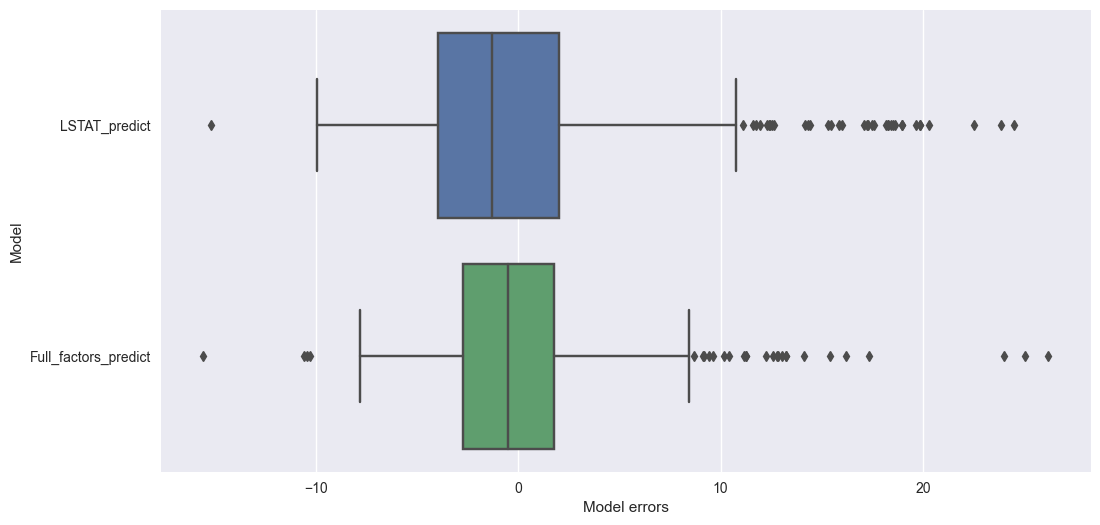

In [21]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) #фигура + координатная плоскость
#Ошибки модели на одном факторе LSTAT
y_errors_lstat = y - lr_lstat.predict(boston_data[['LSTAT']])
#Ошибки модели на всех факторах
y_errors_full = y - lr_full.predict(boston_data[features])
#Для удобства визуализации составим DataFrame из ошибок
errors_df = pd.DataFrame(
    {'LSTAT_predict': y_errors_lstat, 
     'Full_factors_predict': y_errors_full
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=errors_df, orient='h', ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат

*Из построенных диаграмм ошибок видно, что разброс ошибок для модели, построенной на всех признаках, ниже (ящик уже и усы короче), и медиана ошибки также более приближена к 0. То есть можно сказать, что визуально качество второй модели выглядит лучше.*

*На обеих диаграммах присутствуют точки, сильно выбивающиеся за пределы усов. Это наблюдения, для которых модель допустила очень большую ошибку, по сравнению с основной группой.*

*Можно предположить, что это объекты, для которых гипотеза о линейной зависимости несправедлива, и линейной модели не хватает для предсказания целевой переменной для таких объектов. О том, как справиться с этой проблемой, мы поговорим чуть позже.*

Визуализация — это, конечно, хорошо, но, согласитесь, не очень удобно: визуализация не даёт конкретики — только общие представления об ошибках.

Может быть, есть способ описать качество модели каким-то конкретным числом? Да. Этот показатель называется метрикой. 

#### Задание 2.7

В данных появился новый участок со следующими параметрами:
```
CRIM         0.35114
ZN           0.00000
INDUS        7.38000
CHAS         0.00000
NOX          0.49300
RM           6.04100
AGE         49.90000
DIS          4.72110
RAD          5.00000
TAX        287.00000
PTRATIO     19.60000
B          396.90000
LSTAT        7.70000
```
Сделать предсказание медианной стоимости (MEDV) для данного участка c помощью модели lr_full. Результат предсказания в тысячах долларов. Ответ округлить до второго знака после точки-разделителя.

In [22]:
# display(lr_full.predict(X))
new_dict = {
    'CRIM': [0.35114],
    'ZN': [0],
    'INDUS': [7.38000],
    'CHAS': [0],
    'NOX': [0.49300],
    'RM': [6.04100],
    'AGE': [49.90000],
    'DIS': [4.72110],
    'RAD': [5],
    'TAX': [287.00000],
    'PTRATIO': [19.60000],
    'B': [396.90000],
    'LSTAT': [7.70000],
}
X_new = pd.DataFrame(new_dict)
display(X_new)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.35114,0,7.38,0,0.493,6.041,49.9,4.7211,5,287.0,19.6,396.9,7.7


In [23]:
print(round(lr_full.predict(X_new)[0], 2))

22.87


#### Задание 2.8
Дан набор данных о стартапах и их прибыли (в долларах) в трёх различных штатах США.

Столбцы:

- **`R&D Spend`**&nbsp;&mdash; расходы на исследования.
- **`Administration`**&nbsp;&mdash; административные расходы.
- **`Marketing Spend`**&nbsp;&mdash; расходы на маркетинг.
- **`State*`**&nbsp;&mdash; штат.
- **`Profit`**&nbsp;&mdash; прибыль (целевой признак).

Для обучения линейной регрессии использовать `R&D Spend`, `Administration` и `Marketing Spend`. Отделить факторы от целевой переменной.

Обучить модель линейной регрессии методом наименьших квадратов с помощью библиотеки **`numpy`** (воспользоваться формулой из модуля).

Чему равны коэффициенты линейной регрессии при признаках `R&D Spend`, `Administration` и `Marketing Spend`? Ответ ввести с точностью до второго знака после точки-разделителя.

In [24]:
start_df = pd.read_csv('data/50_Startups.csv')
start_df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [25]:
start_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [26]:
X = start_df[['R&D Spend', 'Administration', 'Marketing Spend']]
y = start_df['Profit']
w = linear_regression(X, y)
print(f'Intercept factor: {round(w[0], 2)}')
print(f'R&D factor: {round(w[1], 2)}')
print(f'Admin factor: {round(w[2], 2)}')
print(f'Marketing factor: {round(w[3], 2)}')

Intercept factor: 50122.19
R&D factor: 0.81
Admin factor: -0.03
Marketing factor: 0.03


#### Метрики регрессии. Недостатки аналитического решения

РАСЧЁТ МЕТРИК НА PYTHON


Настало время проверить качество построенных нами ранее моделей линейной регрессии: lr_lstat и lr_full.

Весь набор функций для вычисления метрик в sklearn находится в модуле metrics. Давайте его импортируем:

In [27]:
from sklearn import metrics

Функции, которые нам понадобятся:

* mean_absolute_error() — расчёт MAE;
* mean_squared_error() — расчёт MSE;
* mean_absolute_percentage_error() — расчёт MAPE;
* r2_score() — расчёт коэффициента детерминации .

В каждую из функций достаточно передать правильные ответы и предсказания, и функция вернёт рассчитанную метрику.

*Примечание. Для расчёта метрики RMSE нет специальной функции, однако мы знаем, что для её расчёта достаточно извлечь квадратный корень из MSE.*

*Из-за особенностей реализации функция mean_absolute_percentage_error() возвращает результат не в процентах, а в долях. Чтобы отобразить результат в процентах, необходимо умножить его на 100.*

Давайте вычислим метрики и выведем их на экран, округлив до третьего знака после запятой. Начнём с модели lr_lstat: сделаем предсказание на основании признака LSTAT и передадим истинные и предсказанные медианные цены в функции для расчёта метрик:

In [29]:
y = boston_data.MEDV
#Делаем предсказание по признаку LSTAT
y_predict_lstat = lr_lstat.predict(boston_data[['LSTAT']])
#Рассчитываем MAE
print('MAE score: {:.3f} thou. $'.format(metrics.mean_absolute_error(y, y_predict_lstat)))
#Рассчитываем RMSE
print('RMSE score: {:.3f} thou. $'.format(np.sqrt(metrics.mean_squared_error(y, y_predict_lstat))))
#Рассчитываем MAPE
print('MAPE score: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y, y_predict_lstat) * 100))
#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_predict_lstat)))
 
 
# MAE score: 4.505 thou. $
# RMSE score: 6.203 thou. $
# MAPE score: 21.352 %
# R2 score: 0.544

MAE score: 4.505 thou. $
RMSE score: 6.203 thou. $
MAPE score: 21.352 %
R2 score: 0.544


Проделываем ту же самую операцию для второй модели линейной регрессии, lr_full:

In [30]:
#Делаем предсказание по всем признакам
y_predict_full = lr_full.predict(boston_data[features])
#Рассчитываем MAE
print('MAE score: {:.3f} thou. $'.format(metrics.mean_absolute_error(y, y_predict_full)))
#Рассчитываем RMSE
print('RMSE score: {:.3f} thou. $'.format(np.sqrt(metrics.mean_squared_error(y, y_predict_full))))
#Рассчитываем MAPE
print('MAPE score: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y, y_predict_full) * 100))
#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_predict_full)))
 

# MAE score: 3.271 thou. $
# RMSE score: 4.679 thou. $
# MAPE score: 16.417 %
# R2 score: 0.741

MAE score: 3.271 thou. $
RMSE score: 4.679 thou. $
MAPE score: 16.417 %
R2 score: 0.741


Сравним полученные результаты:

* MAE : в среднем первая модель ошибается на  4.505 тыс. долларов, а вторая — на 3.271 тыс. долларов.
* RMSE : среднеквадратичное отклонение первой модели от истинных ответов составляет 6.203 тыс. долларов, а второй — 4.679.
* MAPE : первая модель ошибается на 21.352 %, а вторая — на 16.417 %.
* R2 : доля объясняемой информации (дисперсии), которую улавливает первая модель, — 0.544, а вторая — 0.741.

Очевидно, что по всем метрикам вторая модель, построенная на основе всех признаков в данных, превосходит первую.

#### Задание 3.2

Есть истинные ответы y_true = [1.23, 2.35, 2.75] и предсказания модели y_pred = [1.01, 12.3, 2.74]. Посчитать метрику RMSE, ответ округлить до двух знаков после точки-разделителя.

In [31]:
y_true = [1.23, 2.35, 2.75]
y_pred = [1.01, 12.3, 2.74]
print(f'RMSE score: {np.sqrt(metrics.mean_squared_error(y_true, y_pred)):.2f}')

RMSE score: 5.75


#### Задание 3.3

Чему равен коэффициент детерминации на следующих данных?

Истинные ответы: y_true = [22.4, 20.6, 23.9, 22.0, 11.9]

Предсказанные ответы: y_pred = [20.5, 20.2, 20.3, 19.0, 11.0]

Ответ округлить до двух знаков после точки-разделителя.

In [32]:
y_true = [22.4, 20.6, 23.9, 22.0, 11.9]
y_pred = [20.5, 20.2, 20.3, 19.0, 11.0]
print(f'R2 score: {metrics.r2_score(y_true, y_pred):.2f}')

R2 score: 0.71


### Линейная регрессия: численное решение

Как и раньше, будем работать с датасетом о домах в Бостоне из библиотеки sklearn.

In [34]:
boston_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


Обучим с помощью градиентного спуска линейную регрессию на одном факторе — LSTAT (процент низкостатусного населения) — и сравним результат с полученным ранее результатом МНК.

In [35]:
X = boston_data[['LSTAT']] #матрица наблюдений
y = boston_data['MEDV'] #вектор правильных ответов

Будем использовать реализацию стохастического градиентного спуска для линейной регрессии из библиотеки sklearn — SGDRegressor. Она находится в том же модуле linear_model.

У класса SGDRegressor есть множество параметров. Например, параметр random_state отвечает за число, на основе которого происходит генерация  случайных чисел. Напомним, в SGD случайность присутствует в инициализации параметров и выборе части из набора данных. Установив значение параметра random_state равным определённому числу, мы можем гарантировать одинаковые результаты работы метода при разных запусках. Пусть это будет число 42.

Для обучения используется метод fit(): он запускает работу градиентного спуска для поиска параметров, в него необходимо передать данные и правильные ответы.

*Примечание. К сожалению, в sklearn нельзя посмотреть то, как происходит поиск оптимальных параметров с помощью SGD. Поэтому нет возможности продемонстрировать историю изменения функции потерь. В модулях по оптимизации мы самостоятельно реализуем алгоритм и посмотрим на поэтапную минимизацию.*

In [36]:
#Создаём объект класса линейной регрессии с SGD
sgd_lr_lstat = linear_model.SGDRegressor(random_state=42)
#Обучаем модель — ищем параметры по методу SGD
sgd_lr_lstat.fit(X, y)

SGDRegressor(random_state=42)

Обучение завершено, параметры найдены. Давайте выведем их на экран. Для этого используются уже знакомые вам атрибуты coef_ и intercept_:

In [37]:
print('w0: {}'.format(sgd_lr_lstat.intercept_)) #свободный член w0
print('w1: {}'.format(sgd_lr_lstat.coef_)) #остальные параметры модели w1, w2, ..., wm

# w0: [34.33010969]
# w1: [-0.96193242]

w0: [34.33010969]
w1: [-0.96193242]


Примечание. Обратите внимание, что значения параметров немного отличаются от полученных ранее с помощью МНК значений. Для МНК коэффициенты были равны:

* w0: [34.55384087938311]
* w1: [-0.95004935]

В этом нет ничего удивительного, ведь МНК — это аналитический метод, он выдаёт точное решение, а SGD — численный, и вычисления останавливаются, когда достигается приемлемая точность.

Давайте с помощью метода predict() сделаем предсказание цены для всех объектов из нашей выборки и построим визуализацию:

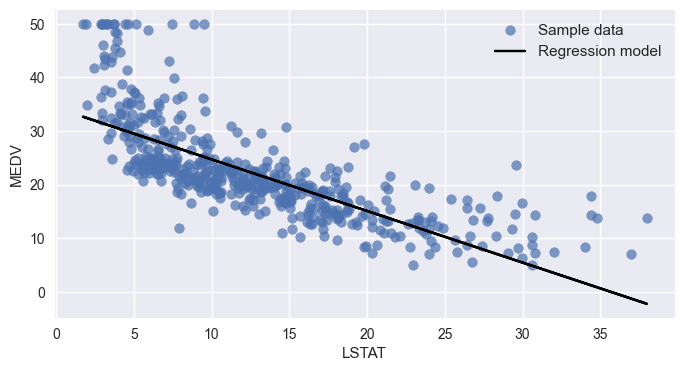

In [38]:
#функция для визуализации регрессии
def plot_regression_2d(X, y_true, y_predict, xlabel='LSTAT', ylabel='MEDV'):
    fig, ax = plt.subplots(figsize=(8, 4)) #фигура + координатная плоскость
    ax.scatter(X, y_true, alpha=0.7, label='Sample data') #диаграмма рассеяния
    ax.plot(X, y_predict, color='black', label='Regression model') #линейный график
    ax.set_xlabel(xlabel) #название оси абсцисс
    ax.set_ylabel(ylabel) #название оси ординат
    ax.legend(facecolor='white', fontsize=11) #легенда
#Предсказываем медианную цену для всех участков из набора данных
y_predict = sgd_lr_lstat.predict(X)
#Строим визуализацию
plot_regression_2d(X, y, y_predict)

Можно рассчитать метрики регрессии для полученной модели. Давайте для примера посчитаем R2:

In [39]:
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_predict)))
# R2 score: 0.542

R2 score: 0.542


Итоговый R2 для линейной регрессии, обученной с помощью градиентного спуска, составил 0.542. Напомним, для той же модели, обученной с помощью МНК, метрика была равна 0.544. То есть доля информации, которую объяснила модель, обученная с помощью градиентного спуска, ниже примерно на 0.002. Очевидно, в реальных задачах такая разница не имеет значения. 

Теперь попробуем обучить многомерную линейную регрессию с помощью SGD. Как и раньше составим полную матрицу наблюдений  из всех факторов, которые нам даны. Обучим модель и выведем значения коэффициентов в виде DataFrame:

In [40]:
#Составляем список факторов (исключили целевой столбец)
features = boston_data.drop('MEDV', axis=1).columns
#Составляем матрицу наблюдений X и вектор ответов y
X = boston_data[features]
y = boston_data['MEDV']
 
#Создаём объект класса линейной регрессии с SGD
sgd_lr_full = linear_model.SGDRegressor(random_state=42)
#Обучаем модель — ищем параметры по методу SGD
sgd_lr_full.fit(X, y)
 
#Составляем таблицу из признаков и их коэффициентов
w_df = pd.DataFrame({'Features': features, 'Coefficients': sgd_lr_full.coef_})
#Составляем строчку таблицы со свободным членом
intercept_df =pd.DataFrame({'Features': ['INTERCEPT'], 'Coefficients': sgd_lr_full.intercept_})
coef_df = pd.concat([w_df, intercept_df], ignore_index=True)
display(coef_df)

,Features,Coefficients
0,CRIM,2.156857e+11
1,ZN,1.248446e+10
2,INDUS,7.277644e+09
3,CHAS,8.306154e+09
4,NOX,-8.413828e+09
5,RM,-3.148182e+10
6,AGE,8.685820e+10
7,DIS,-2.256141e+11
8,RAD,-4.683208e+10
9,TAX,1.892286e+09


Все коэффициенты имеют запредельные значения (9-11 степени числа 10). Это типичная картина расходящегося градиентного спуска: алгоритм не достиг точки минимума по каким-то причинам. Такие высокие значения коэффициентов означают, что модель является неустойчивой.

Давайте сделаем предсказание и выведем R2 для обученной модели:

In [41]:
#Предсказываем медианную цену для всех участков из набора данных
y_predict = sgd_lr_full.predict(X)
#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_predict)))

# R2 score: -10590303862129977211224064.000

R2 score: -10590303862129979358707712.000


R2 отрицательный. Да ещё какой! Напомним, отрицательный  R2 говорит о том, что модель абсолютно не описывает зависимости в данных.

В чём же причина? Неужели SGD не справился с поиском 14 параметров (свободный член + 13 коэффициентов при факторах)?

*→ Ответ очень простой — отсутствие масштабирования. Как мы уже говорили ранее, при использовании градиентного спуска и его модификаций очень важно масштабировать данные с помощью нормализации или стандартизации. Иначе алгоритм теряется в таком растянутом пространстве из-за неравномерных градиентов.*

Давайте стандартизируем наши данные. Воспользуемся классом StandardScaler из модуля preprocessing библиотеки sklearn, который реализует стандартизацию.

In [42]:
from sklearn import preprocessing
 
#Инициализируем стандартизатор StandardScaler
scaler = preprocessing.StandardScaler()
#Производим стандартизацию
X_scaled = scaler.fit_transform(X)
#Составляем DataFrame из результата
X_scaled = pd.DataFrame(X_scaled, columns=features)
X_scaled.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501


Попытка №2. Обучим модель и составим таблицу из её параметров:

In [46]:
#Создаём объект класса линейной регрессии с SGD
sgd_lr_full = linear_model.SGDRegressor(random_state=42)
#Обучаем модель — ищем параметры по методу SGD
#Подаём стандартизованные данные
sgd_lr_full.fit(X_scaled, y)
 
#Составляем таблицу из признаков и их коэффициентов
w_df = pd.DataFrame({'Features': features, 'Coefficients': sgd_lr_full.coef_})
#Составляем строчку таблицы со свободным членом
intercept_df =pd.DataFrame({'Features': ['INTERCEPT'], 'Coefficients': sgd_lr_full.intercept_})
coef_df = pd.concat([w_df, intercept_df], ignore_index=True)
display(coef_df)

,Features,Coefficients
0,CRIM,-0.870552
1,ZN,0.947112
2,INDUS,-0.116802
3,CHAS,0.730289
4,NOX,-1.894276
5,RM,2.757578
6,AGE,-0.027846
7,DIS,-3.049237
8,RAD,1.957066
9,TAX,-1.305271


Вот теперь результат более схож с реальностью. Сделаем предсказание и посчитаем результирующий :

In [47]:
#Предсказываем медианную цену для всех участков из набора данных
#Передаём стандартизованные данные
y_predict = sgd_lr_full.predict(X_scaled)
#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_predict)))

# R2 score: 0.740

R2 score: 0.740


Теперь метрика имеет приемлемое значение, а значит градиентный спуск смог сойтись.

*Важно! Если вы обучили модель на стандартизованных данных, то и для предсказания необходимо передавать их в стандартизованном виде.*

Например, если попытаться сделать предсказание с помощью построенной модели, передав в качестве матрицы наблюдений нестандартизованную таблицу, то ошибки мы не получим, однако значение метрики будет неадекватным:

In [48]:
#Предсказываем медианную цену для всех участков из набора данных
#Передаём стандартизованные данные
y_predict = sgd_lr_full.predict(X)
#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_predict)))

# R2 score: -1856.503

R2 score: -1856.503


![Param_SGDregr](img/param_SGDreg.png)

Давайте посмотрим, что будет, если выставить константный режим управления темпом обучения и задать ему более высокое значение, например 0.1:

In [49]:
#Создаём объект класса линейной регрессии с SGD
sgd_lr_bad = linear_model.SGDRegressor(
    learning_rate='constant', #режим темпа обучения — константа
    eta0=0.1, #начальное и постоянное значение темпа обучения
    random_state=42
)
#Обучаем модель — ищем параметры по методу SGD
#Подаём стандартизованные данные
sgd_lr_bad.fit(X_scaled, y)
#Предсказываем медианную цену для всех участков из набора данных
#Передаём стандартизованные данные
y_predict = sgd_lr_bad.predict(X_scaled)
#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_predict)))

#R2 score: -335415038359.635

R2 score: -335415038359.635


R2<0, то есть SGD разошёлся из-за слишком высокого темпа обучения. 

Вот ещё один плохой пример. Что будет, если поставить слишком маленькое значение параметра eta0? Например, 0.000001.

In [50]:
#Создаём объект класса линейной регрессии с SGD
sgd_lr_bad2 = linear_model.SGDRegressor(
    learning_rate='constant', #режим темпа обучения — константа
    eta0=1e-6, #начальное и постоянное значение темпа обучения
    random_state=42
)
#Обучаем модель — ищем параметры по методу SGD
#Подаём стандартизованные данные
sgd_lr_bad2.fit(X_scaled, y)
#Предсказываем медианную цену для всех участков из набора данных
#Передаём стандартизованные данные
y_predict = sgd_lr_bad2.predict(X_scaled)
#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_predict)))
 
# R2 score: -1.578
# warnings.warn("Maximum number of iteration reached before ")

R2 score: -1.578


c:\Users\jkons\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Снова R2<0, но также мы видим предупреждение (warning), которое говорит о том, что алгоритму не хватило количества итераций (max_iter), чтобы добраться до минимума. То есть SGD не дошёл до точки минимума из-за слишком низкого темпа обучения.

*→ Так как модель линейной регрессии является довольно простой и исследованной, то значения параметров, которые обладают наибольшей эффективностью, уже установлены по умолчанию (аргументы по умолчанию), но бывают ситуации, когда поэкспериментировать с параметрами может быть полезно, чтобы попытаться повысить качество.*

#### Задание 4.9

Найдите в документации параметр `tol`, отвечающий на критерий остановки (по умолчанию он равен 0.001).

Обучить `SGDRegressor` на датасете о домах в Бостоне с параметром остановки, равным 0.1, и `random_state`=42. Остальные параметры оставить по умолчанию.

Рассчитать коэффициент детерминации $R^2$. Ответ округлить до третьего знака после точки-разделителя.

In [51]:
sgd_lr_tol = linear_model.SGDRegressor(tol=0.1, random_state=42)
sgd_lr_tol.fit(X_scaled, y)
y_predict_tol = sgd_lr_tol.predict(X_scaled)
print(f'R2 score: {metrics.r2_score(y, y_predict_tol):.3f}')

R2 score: 0.735


![Metods_OLS_SGDR](img/metods_lin_SGDR.png)

#### Дилемма смещения и разброса. Полиномиальные признаки. Регуляризация

СМЕЩЕНИЕ И РАЗБРОС

Типичным решением является разделение данных на две части: обучающий и тестовый наборы. На тренировочном наборе данных мы будем обучать модель, подбирая параметры. Тестовый набор данных, который модель не видела при обучении, мы будем использовать для оценки истинного качества моделирования. Схематично можно представить это следующим образом:

![train_test](img/train_test.png)

In [52]:
boston_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [53]:
#Составляем список факторов (исключили целевой столбец)
features = boston_data.drop('MEDV', axis=1).columns
#Составляем матрицу наблюдений X и вектор ответов y
X = boston_data[features]
y = boston_data['MEDV']

В sklearn для разделения выборки на тренировочную и тестовую есть функция train_test_split() из модуля model_selection.

 Данная функция принимает следующие аргументы:

* X и y — таблица с примерами и ответами к ним.
* random_state — число, на основе которого генерируются случайные числа. Тренировочная и тестовая выборка генерируются случайно. Чтобы эксперимент был воспроизводимым, необходимо установить этот параметр в конкретное значение.
* test_size — доля тестовой выборки. Параметр определяет, в каких пропорциях будет разделена выборка. Стандартные значения: 70/30, 80/20.

Функция возвращает четыре объекта в следующем порядке: тренировочные примеры, тестовые примеры, тренировочные ответы и тестовые ответы. 

Итак, давайте разделим нашу выборку на тренировочную и тестовую в соотношении 70/30:

In [54]:
from sklearn.model_selection import train_test_split
#Разделяем выборку на тренировочную и тестовую в соотношении 70/30
#Устанавливаем random_state для воспроизводимости результатов 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)
#Выводим результирующие размеры таблиц
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)
 
# Train: (354, 13) (354,)
# Test: (152, 13) (152,)

Train: (354, 13) (354,)
Test: (152, 13) (152,)


После разделения в тренировочной выборке оказались 354 наблюдения, а в тестовой — 152.

Затем обучим линейную регрессию (с помощью МНК) на тренировочных данных и рассчитаем R2 для тренировочных и тестовых данных:

In [55]:
#Создаём объект класса LinearRegression
lr_model = linear_model.LinearRegression()
#Обучаем модель по МНК
lr_model.fit(X_train, y_train)
 
#Делаем предсказание для тренировочной выборки
y_train_predict = lr_model.predict(X_train)
#Делаем предсказание для тестовой выборки
y_test_predict = lr_model.predict(X_test)
 
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict)))

# Train R^2: 0.743
# Test R^2: 0.722

Train R^2: 0.743
Test R^2: 0.722


Итак, R2=0.743 на тренировочной выборке и R2=0.722 на тестовой выборке. То есть показатели довольно близки друг к другу (низкий разброс ответов модели для разных выборок).

Это одно из свидетельств отсутствия переобучения. Это не удивительно, ведь линейная регрессия, построенная на 13 факторах, является довольно простой моделью: всего лишь 14 параметров, что очень мало по меркам машинного обучения. Риск переобучения возрастает с количеством факторов, которые участвуют в обучении модели.

Но что насчёт смещения? Самый простой способ оценить смещение и недообученность модели — посмотреть на значение метрики и интуитивно оценить её.

Может, наша модель слишком слабая? R2=0.722  — не слишком уж высокий показатель (напомним, максимум — 1). Возможно, стоит попробовать обучить более сложную модель. Например, можно построить модель полиномиальной регрессии.

*Примечание. Существуют более совершенные визуальные способы оценить наличие смещения и разброса, такие как кривая обучения и кросс-валидация.*

ПОЛИНОМИАЛЬНЫЕ ПРИЗНАКИ

**Полиномиальная регрессия (Polynomial Regression) — это более сложная модель, чем линейная регрессия. Вместо уравнения прямой используется уравнение полинома (многочлена). Степень полинома может быть сколь угодно большой: чем больше степень, тем сложнее модель.**

*→ Благодаря степенным слагаемым модель становится сложнее и начинает улавливать более сложные зависимости и выдавать меньшее смещение. Но, как вы понимаете, резко повышается риск переобучения модели — увеличивается разброс предсказаний на разных данных из-за количества факторов.*

Построить полиномиальную регрессию в sklearn очень просто. Для начала необходимо создать полиномиальные признаки с помощью объекта класса PolynomialFeatures из модуля preprocessing. Это преобразователь, который позволит сгенерировать полиномиальные признаки любой степени и добавить их в таблицу. У него есть два важных параметра:

* degree — степень полинома. По умолчанию используется степень 2.
* include_bias — включать ли в результирующую таблицу столбец из единиц (x в степени 0). По умолчанию стоит True, но лучше выставить его в значение False, так как столбец из единиц и так добавляется в методе наименьших квадратов.

*Примечание. Как правило, дата-сайентисты останавливаются на полиноме второй (максимум третьей) степени. Чем выше степень полинома, тем больше слагаемых, а значит, тем больше признаков и тем сложнее становится модель.*

Для того чтобы подогнать генератор и рассчитать количество комбинаций степеней, мы используем метод fit(), а чтобы сгенерировать новую таблицу признаков, в которую будут включены полиномиальные признаки, используется метод transform(), в который нужно передать выборки:

In [56]:
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.transform(X_train)
#Генерируем полиномиальные признаки для тестовой выборки
X_test_poly = poly.transform(X_test)
#Выводим результирующие размерности таблиц
print(X_train_poly.shape)
print(X_test_poly.shape)
 
# (354, 104)
# (152, 104)

(354, 104)
(152, 104)


Итак, мы сгенерировали новые тренировочные и тестовые наборы данных. В каждой таблице в дополнение к 13 изначальным признакам добавилась 91 полиномиальная комбинация степени 2.

В результате мы получили два numpy-массива:

In [57]:
print(type(X_train_poly))
print(type(X_test_poly))
# <class 'numpy.ndarray'>
# <class 'numpy.ndarray'>

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Теперь попробуем скормить наши данные модели линейной регрессии, чтобы найти коэффициенты полинома по МНК-алгоритму:

In [58]:
#Создаём объект класса LinearRegression
lr_model_poly = linear_model.LinearRegression()
#Обучаем модель по МНК
lr_model_poly.fit(X_train_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lr_model_poly.predict(X_train_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = lr_model_poly.predict(X_test_poly)
 
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))

# Train R^2: 0.929
# Test R^2: 0.268

Train R^2: 0.929
Test R^2: 0.268


Потрясающе! На тренировочной выборке коэффициент детерминации R2=0.929, то есть наша модель описывает почти 93 % зависимости в данных.

Смотрим на показатели тестовой выборки и сразу «спускаемся с небес на землю»: R2=0.268 . Метрика значительно ниже, чем на тренировочном наборе. Это и есть переобучение модели. Из-за своей сложности (количества факторов) модель полностью адаптировалась под тренировочные данные, но взамен получила высокий разброс в показателях на данных, которые она не видела ранее. 

*Примечание. Модель линейной регрессии может быть неустойчивой, даже если показатели на тренировочной и тестовой выборках довольно близки, однако все коэффициенты уравнения имеют огромные значения.*

Такая модель никому не нужна, так как она не отражает действительности.

Однако не стоит расстраиваться — есть один замечательный метод, который сможет спасти нашу модель от переобучения, и это **регуляризация**.

РЕГУЛЯРИЗАЦИЯ

***Регуляризация** — способ уменьшения переобучения моделей машинного обучения.*

Идея регуляризации состоит в том, что мы намеренно пытаемся увеличить смещение модели, чтобы уменьшить разброс. Закон баланса в действии!

Но как можно увеличить смещение модели? Мы можем «наказывать» модель за обучение сложным взаимосвязям. 

Математически это будет очень простая операция — добавление к функции потерь некоторого штрафа.

***Штраф** — это дополнительное неотрицательное слагаемое в выражении для функции потерь, которое специально повышает ошибку.  За счёт этого слагаемого метод оптимизации (OLS или SGD) будет находить не истинный минимум функции потерь, а псевдоминимум.*

Есть несколько способов добавления штрафа к функции потерь:

![regular](img/regular.png)

***Коэффициенты a(альфа)** — это коэффициенты регуляризации. Они отвечают за то, насколько сильное смещение мы будем вносить в модель: чем оно больше , тем сильнее будет штраф за переобучение.*

![Lagrange](img/lagrange.png)

А теперь пора приниматься за практику!

Практика показывает, что обучение линейной регрессии с большим количеством признаков рекомендуется производить на стандартизованных (нормализованных) данных.

*Примечание. Часто возникает вопрос: как правильно проводить стандартизацию/нормализацию при наличии тренировочной и тестовой выборки?*

*Вы обучаете (fit()) преобразование на тренировочной выборке и используете его с одними и теми же параметрами на тренировочной и тестовой выборке (transform()). Если производить подгонку на каждой из выборок в отдельности, вы внесёте смещение в модель.*

Стандартизацию (нормализацию) полезнее проводить перед генерацией полиномиальных признаков, иначе можно потерять масштаб полиномов.

Давайте предобработаем наши данные:

In [59]:
#Инициализируем стандартизатор StandardScaler
scaler = preprocessing.StandardScaler()
#Подгоняем параметры стандартизатора (вычисляем среднее и СКО)
scaler.fit(X_train)
#Производим стандартизацию тренировочной выборки
X_train_scaled = scaler.transform(X_train)
#Производим стандартизацию тестовой выборки
X_test_scaled = scaler.transform(X_test)
 
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_scaled_poly = poly.transform(X_train_scaled)
#Генерируем полиномиальные признаки для тестовой выборки
X_test_scaled_poly = poly.transform(X_test_scaled)
#Выводим результирующие размерности таблиц
 
print(X_train_scaled_poly.shape)
print(X_test_scaled_poly.shape)
# (354, 104)
# (152, 104)

(354, 104)
(152, 104)


*→ В sklearn методы регуляризации реализованы в классах **Lasso (L1-регуляризация)** и **Ridge (L2-регуляризация)**. Оба метода осуществляют поиск параметров с добавлением регуляризации. Процесс обучения и предсказания не отличается от обычной линейной регрессии.*

Давайте построим модель линейной регрессии с L1-регуляризацией на сгенерированных нами ранее полиномиальных признаках.

Главный параметр инициализации Lasso — это alpha, коэффициент регуляризации. По умолчанию alpha=1. Практика показывает, что это довольно сильная регуляризация для L1-метода. Давайте установим значение этого параметра на 0.1.

In [60]:
#Создаём объект класса линейной регрессии с L1-регуляризацией
lasso_lr_poly = linear_model.Lasso(alpha=0.1)
#Обучаем модель
lasso_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))

# Train R^2: 0.879
# Test R^2: 0.882

Train R^2: 0.879
Test R^2: 0.882


Обратите внимание на то, как изменились значения метрик. Да, на тренировочной выборке R2=0.879. Метрика упала (до стандартизации + регуляризации значение R2 было 0.929). Однако метрика ощутимо выросла на тестовой выборке: R2=0.882 (ранее она была равна 0.268). Мы смогли преодолеть переобучение.

Давайте выведем значения коэффициентов модели, округлив их до третьего знака после запятой:

In [61]:
print(np.round(lasso_lr_poly.coef_, 3))

[-0.     0.    -0.038  0.    -0.523  2.766 -0.355 -0.605  0.    -0.595
 -0.763  0.    -3.259 -0.    -0.     0.     3.132 -0.141  0.     0.
  0.    -0.     0.     0.    -0.015 -0.     0.063 -0.    -0.     0.
  0.159 -0.    -0.    -0.     0.     0.07  -0.    -0.     0.017  0.
  0.    -0.     0.     0.     0.     0.    -0.    -0.     0.     0.46
 -0.808 -0.643  0.    -0.    -0.     0.    -0.     0.    -0.43  -0.348
 -0.511 -0.     0.    -0.14  -0.    -0.277  0.    -0.     0.223 -0.
 -0.    -0.836 -0.054 -0.421  0.019 -0.784  0.    -0.     0.706  0.
 -0.    -0.335 -0.198  0.    -0.     0.     0.205 -0.     0.531 -0.
  0.     0.048 -0.    -0.292  0.677  0.81  -0.    -1.151 -0.    -0.
 -0.    -0.288 -0.356  0.429]


*Обратите внимание: большая часть коэффициентов обнулилась. Это значит, что признаки, которые соответствуют этим коэффициентам, не используются в прогнозе модели Lasso-регрессии.*

Теперь давайте на тех же данных обучим модель линейной регрессии с L2-регуляризацией. Для L2-регуляризации параметр alpha по умолчанию равен 1. Давайте попробуем использовать значение параметра alpha=10:

In [62]:
#Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr_poly = linear_model.Ridge(alpha=10)
#Обучаем модель
ridge_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = ridge_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = ridge_lr_poly.predict(X_test_scaled_poly)
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))
 

# Train R^2: 0.907
# Test R^2: 0.831

Train R^2: 0.907
Test R^2: 0.848


*Значения метрики R2 на тестовой выборке для L1-регуляризации получились немного выше. В первую очередь мы всегда ориентируемся на тестовую выборку — это данные, которые модель ещё не видела.*

Давайте выведем значения коэффициентов модели, округлив их до третьего знака после запятой:

In [63]:
print(np.round(ridge_lr_poly.coef_, 3))

[ 0.128 -0.049  0.084  0.117 -0.932  2.848 -1.008 -1.464  0.909 -0.908
 -0.653  0.971 -2.605  0.085 -0.032  0.466  2.721 -0.507  0.986  0.309
 -0.391 -0.714  0.376 -0.379  0.072  0.287  0.143 -0.138 -0.014  0.315
  0.05  -0.409 -0.316  0.075  0.702  0.08  -0.281 -0.37   0.511  0.175
  0.72   0.282  0.477  0.888 -0.012  0.074 -0.052  0.166 -0.263  0.414
 -1.129 -0.852  0.273  0.227 -0.106  0.368 -0.137 -0.241 -0.697 -0.177
 -0.326 -0.524  0.882 -0.637  0.344 -0.439 -0.006  0.386  0.233 -0.535
  0.111 -0.802 -0.662 -0.56   0.22  -1.001  0.123  0.144  0.889 -0.114
 -0.086 -1.022 -0.71   1.08  -0.446 -0.178 -0.07  -0.496  0.874 -0.926
  0.717  0.601 -0.49  -0.723  0.308  1.086 -0.448 -1.256  0.057  0.354
 -0.059 -0.433 -0.791  0.177]


Видно, что L2-регуляризация не обнуляет коэффициенты — она использует для предсказания все признаки.

*Параметр **alpha** имеет очень важное значение: от его выбора зависит, как сильно мы будем штрафовать модель за переобучение. Важно найти значение, которое приносит наилучший эффект.*

*Попробуйте вручную изменять параметр **alpha** для построенных ранее моделей. Согласитесь, это не очень удобно.*

Давайте организуем процесс перебора параметров модели: создадим цикл, в котором будем перебирать 20 различных значений alpha в диапазоне от 0.001 до 1. Такой список проще всего создать с помощью функции linspace() из библиотеки numpy.

В цикле будем обучать модель линейной регрессии и L1-регуляризацией (Lasso), вычислять значения метрики R2 на тренировочной и тестовой выборках и заносить результаты в списки train_scores и test_scores:

In [64]:
#Создаём список из 20 возможных значений от 0.001 до 1
alpha_list = np.linspace(0.001, 1, 20)
#Создаём пустые списки, в которые будем добавлять результаты 
train_scores = []
test_scores = []
for alpha in alpha_list:
    #Создаём объект класса линейной регрессии с L1-регуляризацией
    lasso_lr_poly = linear_model.Lasso(alpha=alpha, max_iter=10000)
    #Обучаем модель
    lasso_lr_poly.fit(X_train_scaled_poly, y_train)
    #Делаем предсказание для тренировочной выборки
    y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
    #Делаем предсказание для тестовой выборки
    y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)
    #Рассчитываем коэффициенты детерминации для двух выборок и добавляем их в списки
    train_scores.append(metrics.r2_score(y_train, y_train_predict_poly))
    test_scores.append(metrics.r2_score(y_test, y_test_predict_poly))

В результате выполнения данного кода в списках train_scores и test_scores появятся 20 различных значений  на тренировочной и тестовой выборках.

Давайте построим линейные графики, которые покажут, как меняется метрика  на тренировочной и тестовой выборках в зависимости от alpha:

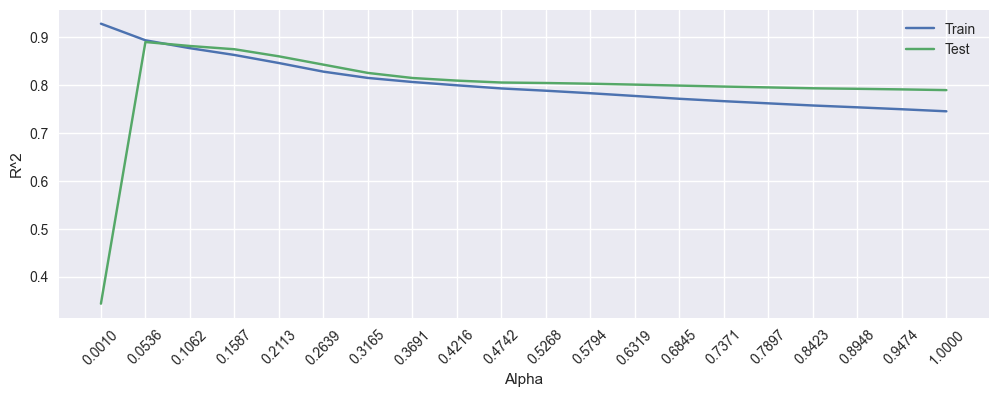

In [65]:
#Визуализируем изменение R^2 в зависимости от alpha
fig, ax = plt.subplots(figsize=(12, 4)) #фигура + координатная плоскость
ax.plot(alpha_list, train_scores, label='Train') #линейный график для тренировочной выборки
ax.plot(alpha_list, test_scores, label='Test') #линейный график для тестовой выборки
ax.set_xlabel('Alpha') #название оси абсцисс
ax.set_ylabel('R^2') #название оси ординат
ax.set_xticks(alpha_list) #метки по оси абсцисс
ax.xaxis.set_tick_params(rotation=45) #поворот меток на оси абсцисс
ax.legend(); #отображение легенды

*С помощью графика мы можем подобрать оптимальное значение параметра **alpha**. Нам нужна такая точка на оси абсцисс, при которой на тестовой выборке наблюдается максимальная метрика и при этом разница между метриками на тренировочной и тестовой выборках минимальна.*

*Видно, что R2 на тестовой выборке достигает наибольшего значения в точке 0.0536. Причём в этой точке наблюдается примерное равенство метрик на каждом наборе данных. Далее метрика на тестовой выборке начинает падать.*

*Обратите внимание, что на тренировочной выборке R2 непрерывно падает с ростом **alpha**. Оно и понятно, ведь чем больше **alpha**, тем сильнее регуляризация и тем меньше модель подстраивается под обучающую выборку.*

Давайте подставим значение alpha=0.0536 в модель Lasso и получим результат:

In [66]:
#Создаём объект класса линейной регрессии с L1-регуляризацией
lasso_lr_poly = linear_model.Lasso(alpha=0.0536)
#Обучаем модель 
lasso_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))

# Train R^2: 0.894
# Test R^2: 0.890

Train R^2: 0.894
Test R^2: 0.890


Итак, метрика R2 выросла благодаря тому, что мы смогли подобрать оптимальное значение параметра **alpha**.

![Elasic Net](img/elastic_net.png)

### Практика по линейной регрессии с популярным датасетом Medical Cost Personal Datasets

Настало время попрактиковаться применять модель линейной регрессии и её модификации в задачах регрессии.

В этот раз мы коснёмся мира медицинского страхования. Нашей целью будет предсказать индивидуальные медицинские расходы граждан США, оплачиваемые медицинской страховкой.

Необходимые нам библиотеки:

In [68]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #разделение выборки

Прочитаем данные:

In [67]:
data_df = pd.read_csv('data/insurance.csv')
data_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Итак, набор данных содержит следующие столбцы:

![Teg](img/teg.png)

In [69]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Размер таблицы:

In [71]:
print(data_df.shape)
# (1338, 7)

(1338, 7)


Выведем информацию о пропусках, так как наличие пропусков не позволит нам построить модель линейной регрессии:

In [72]:
display(data_df.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Пропуски в таблице отсутствуют.

Посмотрим на типы данных:

In [73]:
display(data_df.dtypes)

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [74]:
copy_df = data_df.copy()

Наши данные содержат несколько типов признаков:

![priznaki](img/priznaki.png)

![issledovanie](img/issledov.png)

Мы знаем, что модель линейной регрессии не умеет работать с категориальными признаками, поэтому категории необходимо перекодировать.

Кодировку будем совершать по следующему принципу:

* smoker — переведём в бинарные значения (0 — некурящий, 1 — курящий);
* sex — аналогично (0 — female, 1 — male);
* region — используем OneHot-кодирование (воспользуемся функцией get_dummies).

In [75]:
#кодируем бинарные категориальные признаки
copy_df['smoker'] = copy_df['smoker'].apply(lambda x: 0 if x == 'no' else 1)
copy_df['sex'] = copy_df['sex'].apply(lambda x: 0 if x == 'female' else 1)
#оставшиеся категориальные признаки кодируем с помощью OneHot
copy_df = pd.get_dummies(copy_df)
copy_df.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


In [76]:
copy_df.describe()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.505232,30.663397,1.094918,0.204783,13270.422265,0.242152,0.242900,0.272048,0.242900
std,14.049960,0.500160,6.098187,1.205493,0.403694,12110.011237,0.428546,0.428995,0.445181,0.428995
min,18.000000,0.000000,15.960000,0.000000,0.000000,1121.873900,0.000000,0.000000,0.000000,0.000000
25%,27.000000,0.000000,26.296250,0.000000,0.000000,4740.287150,0.000000,0.000000,0.000000,0.000000
50%,39.000000,1.000000,30.400000,1.000000,0.000000,9382.033000,0.000000,0.000000,0.000000,0.000000
75%,51.000000,1.000000,34.693750,2.000000,0.000000,16639.912515,0.000000,0.000000,1.000000,0.000000
max,64.000000,1.000000,53.130000,5.000000,1.000000,63770.428010,1.000000,1.000000,1.000000,1.000000


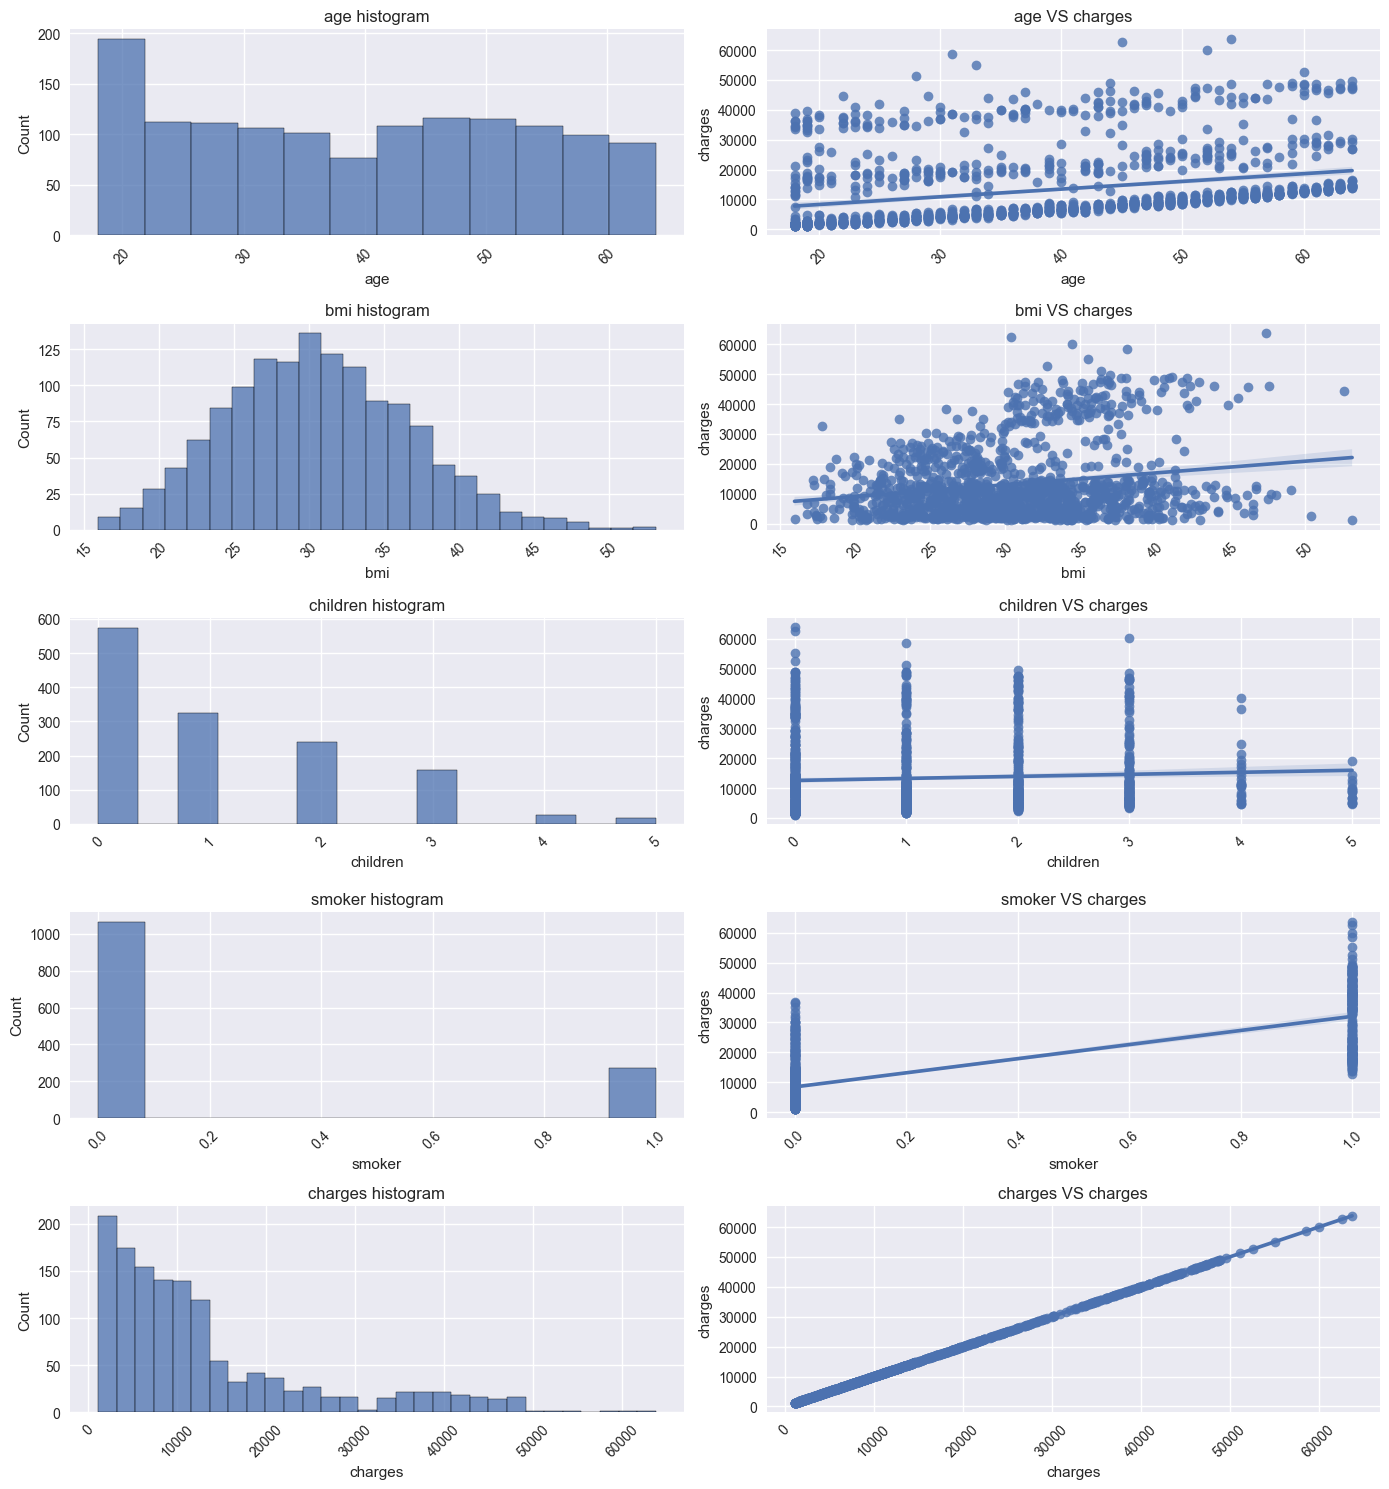

In [77]:
features_list = ['age', 'bmi', 'children', 'smoker', 'charges']
n = len(features_list)
fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(14, 3*n))
for m_, feature in enumerate(features_list):
    hplot = sns.histplot(
        data=copy_df,
        x=feature,
        ax=axes[m_][0]
    )
    hplot.set_title(f'{feature} histogram')
    hplot.xaxis.set_tick_params(rotation=45)
    rplot = sns.regplot(
        data=copy_df,
        x=feature,
        y='charges',
        ax=axes[m_][1]
    )
    rplot.set_title(f'{feature} VS charges')
    rplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout();

<AxesSubplot: >

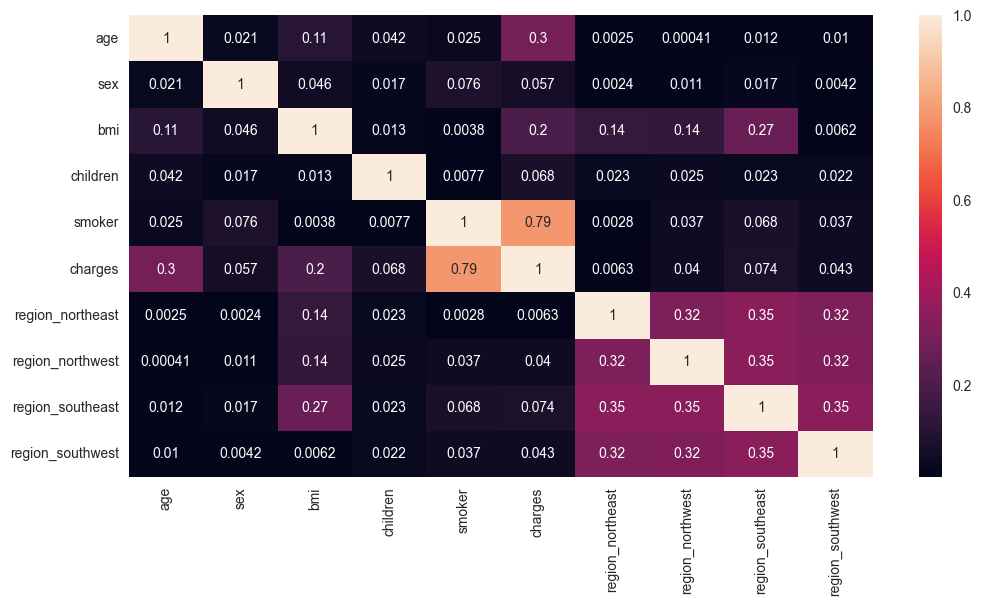

In [78]:
fig = plt.figure(figsize=(12, 6))
sns.heatmap(copy_df.corr().abs(), annot=True)

Итак, мы получили перекодированную таблицу, в которой все признаки являются числовыми.

Выделим факторы и целевой признак в отдельные таблицы:

In [79]:
features = copy_df.drop('charges', axis=1).columns
X, y = copy_df[features], copy_df['charges']

Теперь мы можем начинать работу над моделью ↓

#### Задание 6.1

Прежде чем переходить к этапу моделирования, нам необходимо позаботиться о создании выборки для тестирования модели.


Разделить набор данных на тренировочную и тестовую выборки в соотношении 80/20. Воспользоваться функцией `train_test_split`. В качестве значения параметра `random_state` указать число 42.

Чему равно количество наблюдений в тестовом наборе данных?


In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: (1070, 9) (1070,)
Test set: (268, 9) (268,)


#### Задание 6.2

Обучить модель линейной регрессии аналитическим методом (`LinearRegression`) на тренировочном наборе данных. Все параметры оставить по умолчанию.

Чему равен свободный член (`intercept`) обученной модели? Ответ округлить до сотых.


In [81]:
lr_charges = linear_model.LinearRegression()
lr_charges.fit(X_train, y_train)
print(f'w0: {lr_charges.intercept_:.2f}')
print(f'w1: {lr_charges.coef_}')

w0: -12390.80
w1: [ 2.56975706e+02 -1.85916916e+01  3.37092552e+02  4.25278784e+02
  2.36511289e+04  4.59585244e+02  8.89079180e+01 -1.98279052e+02
 -3.50214110e+02]


#### Задание 6.3

С помощью модели, полученной в предыдущем задании, сделать предсказание на тренировочной и тестовой выборке. Рассчитать следующие три метрики: $R^2$, $MAE$, $MAPE$. Не забыть привести значение $MAPE$ к процентам.

Значение $R^2$ округлить до трёх знаков после точки-разделителя, а значения $MAE$ и $MAPE$&nbsp;&mdash; до целого числа.

Чему равны значения метрик на тренировочной и тестовой выборках?

In [82]:
y_train_predict = lr_charges.predict(X_train)
y_test_predict = lr_charges.predict(X_test)

print(f'Train R2 score: {metrics.r2_score(y_train, y_train_predict):.3f}')
print(f'Train MAE: {round(metrics.mean_absolute_error(y_train, y_train_predict))}')
print(f'Train MAPE: {round(metrics.mean_absolute_percentage_error(y_train, y_train_predict) * 100)}')
                    
print(f'Test R2 score: {metrics.r2_score(y_test, y_test_predict):.3f}')
print(f'Test MAE: {round(metrics.mean_absolute_error(y_test, y_test_predict))}')
print(f'Test MAPE: {round(metrics.mean_absolute_percentage_error(y_test, y_test_predict) * 100)}')

Train R2 score: 0.742
Train MAE: 4208
Train MAPE: 42
Test R2 score: 0.784
Test MAE: 4181
Test MAPE: 47


#### Задание 6.4

Построить диаграмму **boxplot** для визуализации ошибок модели линейной регрессии на тренировочной и тестовой выборках. В качестве ошибки взять разницу между истинным ответом и предсказанием: (без модуля).

Выбрать верные ответы:
- **(False)** Разброс ошибок на тестовой выборке больше, чем на тренировочной.
- **(True)** Разброс ошибок на тренировочной выборке больше, чем на тестовой.
- **(True)** Медианная ошибка на тренировочной и тестовой выборках отрицательная (меньше 0).
- **(False)** Медианная ошибка на тренировочной и тестовой выборках положительная (больше 0)

In [83]:
y_errors_train = y_train - lr_charges.predict(X_train)
y_errors_test = y_test - lr_charges.predict(X_test)

In [84]:
errors_df = pd.DataFrame({'Train': y_errors_train, 'Test': y_errors_test})

Text(0, 0.5, 'Sets')

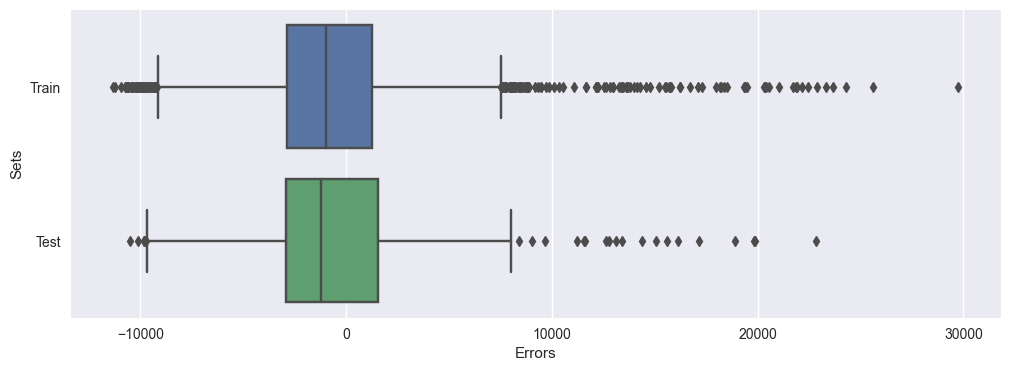

In [85]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.boxplot(
    data=errors_df,
    orient='h',
    ax=ax
)
ax.set_xlabel('Errors')
ax.set_ylabel('Sets')

#### Задание 6.5

Нормализовать тренировочную и тестовую выборки с помощью min-max-нормализации (`MinMaxScaler`). Расчёт параметров нормализации (`fit`) произвести на тренировочной выборке.

***Примечание***    
Min-max-нормализация не искажает изначальный вид бинарных категориальных признаков, в отличие от стандартизации.

На нормализованных данных сгенерировать полиномиальные признаки степени 2. Воспользоваться классом `PolynomialFeatures` из библиотеки `sklearn`. Значение параметра `include_bias` выставить на `False`.

Чему равно результирующее количество столбцов?


In [86]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
##### X_train_scaled = pd.DataFrame(X_train_scaled, columns=features)

X_test_scaled = scaler.transform(X_test)
##### X_test_scaled = pd.DataFrame(X_test_scaled, columns=features)

In [87]:
polyn = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
polyn.fit(X_train_scaled)
X_train_polyn = polyn.transform(X_train_scaled)
X_test_polyn = polyn.transform(X_test_scaled)
print('Train:', X_train_polyn.shape)
print('Test:', X_test_polyn.shape)

Train: (1070, 54)
Test: (268, 54)


#### Задание 6.6

Обучить модель линейной регрессии на полиномиальных признаках.

Чему равно значение метрики $R^2$ на тестовой выборке? Значение $R^2$ округлить до трёх знаков после запятой.

In [88]:
model_polyn = linear_model.LinearRegression()
model_polyn.fit(X_train_polyn, y_train)
y_train_predict_polyn = model_polyn.predict(X_train_polyn)
y_test_predict_polyn = model_polyn.predict(X_test_polyn)
print(f'Train R2 score: {metrics.r2_score(y_train, y_train_predict_polyn):.3f}')
print(f'Test R2 score: {metrics.r2_score(y_test, y_test_predict_polyn):.3f}')

Train R2 score: 0.842
Test R2 score: 0.866


#### Задание 6.7

Вывести значения коэффициентов полученной модели. Обратить внимание на степени коэффициентов.

***Ответ - Значения коэффициентов очень высокие, модель неустойчива, необходима регуляризация.***

In [89]:
print(model_polyn.coef_)

[-4.44086718e+16  1.03241367e+17  3.93148732e+14 -1.35827371e+14
 -4.54647529e+14 -4.40523872e+16 -2.87357345e+16 -3.09303781e+16
 -2.20967116e+16  8.35200000e+03  8.82000000e+02  1.05200000e+03
 -1.67800000e+03  1.72000000e+02  4.44086718e+16  4.44086718e+16
  4.44086718e+16  4.44086718e+16 -8.17850273e+16  6.73000000e+02
 -1.26425000e+03  2.70750000e+02 -2.14563400e+16 -2.14563400e+16
 -2.14563400e+16 -2.14563400e+16 -9.65518750e+03  1.58506250e+03
  5.48798750e+04 -3.93148732e+14 -3.93148732e+14 -3.93148732e+14
 -3.93148732e+14 -2.01800000e+03 -2.22600000e+03  1.35827371e+14
  1.35827371e+14  1.35827371e+14  1.35827371e+14  8.29406920e+14
 -3.74759391e+14 -3.74759391e+14 -3.74759391e+14 -3.74759391e+14
 -1.90001225e+15  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.72166649e+16  0.00000000e+00  0.00000000e+00 -1.50220214e+16
  0.00000000e+00 -2.38556879e+16]


#### Задание 6.8

Построить линейную регрессию с L1-регуляризацией (`Lasso`) на полиномиальных признаках. В качестве параметра `alpha` использовать значение по умолчанию, параметр `max_iter` установить в значение 2000.

Чему равны метрики $R^2$, $MAE$ и $MAPE$ на тестовой выборке? Значение $R^2$ округлить до трёх знаков после запятой, а значения $MAE$ и $MAPE$ до целого числа.

In [90]:
l1_polyn = linear_model.Lasso(max_iter=2000)
l1_polyn.fit(X_train_polyn, y_train)

y_train_polyn_predict = l1_polyn.predict(X_train_polyn)
y_test_polyn_predict = l1_polyn.predict(X_test_polyn)

print(f'Train R2 score: {metrics.r2_score(y_train, y_train_polyn_predict):.3f}')
print(f'Train MAE: {round(metrics.mean_absolute_error(y_train, y_train_polyn_predict))}')
print(f'Train MAPE: {round(metrics.mean_absolute_percentage_error(y_train, y_train_polyn_predict) * 100)}')

print(f'Test R2 score: {metrics.r2_score(y_test, y_test_polyn_predict):.3f}')
print(f'Test MAE: {round(metrics.mean_absolute_error(y_test, y_test_polyn_predict))}')
print(f'Test MAPE: {round(metrics.mean_absolute_percentage_error(y_test, y_test_polyn_predict) * 100)}')

Train R2 score: 0.842
Train MAE: 2890
Train MAPE: 29
Test R2 score: 0.867
Test MAE: 2719
Test MAPE: 30


In [91]:
print(np.round(l1_polyn.coef_))

[ 3.2420e+03 -4.9200e+02  5.0760e+03  4.5840e+03  1.9790e+03  1.8800e+02
 -4.7100e+02  5.8400e+02 -2.4400e+02  8.2980e+03  7.7500e+02  8.4400e+02
 -1.2080e+03  1.3500e+02 -1.0430e+03 -0.0000e+00  1.1700e+03  1.6180e+03
 -0.0000e+00  5.0600e+02 -1.1340e+03  2.6600e+02 -1.2220e+03  0.0000e+00
  2.3600e+02 -5.8000e+02 -8.1800e+03  1.2950e+03  5.4715e+04  3.5850e+03
  2.4070e+03 -9.6400e+02  0.0000e+00 -1.6750e+03 -2.0540e+03  1.9420e+03
  1.9540e+03 -0.0000e+00 -1.0640e+03  8.0000e+00  5.9400e+02 -0.0000e+00
 -2.3100e+02  1.9790e+03  6.3200e+02  0.0000e+00  0.0000e+00  0.0000e+00
 -0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00 -1.0000e+00]


#### Задание 6.9

Построить линейную регрессию с L2-регуляризацией на полиномиальных признаках. В качестве параметра `alpha` использовать значение по умолчанию.

Чему равны метрики $R^2$, $MAE$ и $MAPE$ на тестовой выборке? Значение $R^2$ округлить до трёх знаков после запятой, а значения $MAE$ и $MAPE$ до целого числа.

In [92]:
l2_polyn = linear_model.Ridge()
l2_polyn.fit(X_train_polyn, y_train)

y_train_polyn_predict = l2_polyn.predict(X_train_polyn)
y_test_polyn_predict = l2_polyn.predict(X_test_polyn)

print(f'Train R2 score: {metrics.r2_score(y_train, y_train_polyn_predict):.3f}')
print(f'Train MAE: {round(metrics.mean_absolute_error(y_train, y_train_polyn_predict))}')
print(f'Train MAPE: {round(metrics.mean_absolute_percentage_error(y_train, y_train_polyn_predict) * 100)}')

print(f'Test R2 score: {metrics.r2_score(y_test, y_test_polyn_predict):.3f}')
print(f'Test MAE: {round(metrics.mean_absolute_error(y_test, y_test_polyn_predict))}')
print(f'Test MAPE: {round(metrics.mean_absolute_percentage_error(y_test, y_test_polyn_predict) * 100)}')

Train R2 score: 0.839
Train MAE: 2949
Train MAPE: 30
Test R2 score: 0.863
Test MAE: 2861
Test MAPE: 31
